KIVORK / Junior Product Analyst / Antonov Alexander

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import seaborn as sns
from scipy import optimize
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
data = pd.read_csv('data.csv', sep=';')
data.head()

,product_id,quantity,is_trial_period,purchase_date,user_id
0,1week_4.99_USD_subscription_7days_trial,1,ЛОЖЬ,19.02.2020,9484222
1,1week_4.99_USD_subscription_7days_trial,1,ЛОЖЬ,17.02.2020,9422402
2,1week_4.99_USD_subscription_7days_trial,1,ЛОЖЬ,18.02.2020,4997991
3,1week_4.99_USD_subscription_7days_trial,1,ЛОЖЬ,18.02.2020,9455582
4,1week_4.99_USD_subscription_7days_trial,1,ЛОЖЬ,16.02.2020,8803657


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114200 entries, 0 to 114199
Data columns (total 5 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   product_id       114200 non-null  object
 1   quantity         114200 non-null  int64 
 2   is_trial_period  114200 non-null  object
 3   purchase_date    114200 non-null  object
 4   user_id          114200 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 4.4+ MB


Change the data type in the column with the purchase_date. Columns with the value of the trial period to lowercase and name of the product, after - look at the number of duplicates:

In [4]:
data['purchase_date'] = pd.to_datetime(data.purchase_date, dayfirst=True)
data['product_id'] = data['product_id'].str.lower()
data['is_trial_period'] = data['is_trial_period'].str.lower()
data.duplicated().sum()

84

Remove completely duplicated lines:

In [5]:
data = data.drop_duplicates().reset_index(drop=True)
data.duplicated().sum()

0

Change the name of the column with the date of purchase to "event date", and also place them in a more logical sequence:

In [6]:
data.rename(columns = {'purchase_date': 'event_dt'}, inplace=True)
data['is_trial_period'] = data['is_trial_period'].map({'истина': True, 'ложь': False})
data = data.reindex(columns=['user_id', 'product_id', 'is_trial_period', 'quantity', 'event_dt'])

#### 1. 1. Calculate the user's current LTV using cohort analysis (cohorting event - registration of the trial period, the cohort represents the number of possible operations).

Let's see what date range we have:

In [7]:
data['event_dt'].min()

Timestamp('2020-01-01 00:00:00')

In [8]:
data['event_dt'].max()

Timestamp('2020-02-20 00:00:00')

Add a column with the date of the first session (i.e. registration of the trial period in the app):

In [9]:
first_session = data.groupby(['user_id']).agg({'event_dt':'min'})
first_session.columns = ['first_session']
data = data.join(first_session, on='user_id')
data.head()

,user_id,product_id,is_trial_period,quantity,event_dt,first_session
0,9484222,1week_4.99_usd_subscription_7days_trial,False,1,2020-02-19,2020-02-12
1,9422402,1week_4.99_usd_subscription_7days_trial,False,1,2020-02-17,2020-02-10
2,4997991,1week_4.99_usd_subscription_7days_trial,False,1,2020-02-18,2020-02-11
3,9455582,1week_4.99_usd_subscription_7days_trial,False,1,2020-02-18,2020-02-11
4,8803657,1week_4.99_usd_subscription_7days_trial,False,1,2020-02-16,2020-01-19


Add the "revenue" column: if the trial period is 0 dollars, if the registration is a paid subscription: - 4.99

In [10]:
data['revenue'] = np.where(data['is_trial_period'] == False, '4.99', '0')
data['revenue'] = data['revenue'].astype(float)

Let's add columns with the date of the beginning of the week when the trial period was completed, as well as a column with the date of the beginning of the week when any action was taken by the user. We also define lifetime:

In [11]:
data['first_week'] = data['first_session'] - data['first_session'].dt.weekday.astype('timedelta64[D]')
data['event_week'] = data['event_dt'] - data['event_dt'].dt.weekday.astype('timedelta64[D]')
data['lifetime'] = data['event_week'] - data['first_week']
data['lifetime'] = data['lifetime'] / np.timedelta64(1,'W')
data['lifetime'] = data['lifetime'].round().astype('int')
data.head()

,user_id,product_id,is_trial_period,quantity,event_dt,first_session,revenue,first_week,event_week,lifetime
0,9484222,1week_4.99_usd_subscription_7days_trial,False,1,2020-02-19,2020-02-12,4.99,2020-02-10,2020-02-17,1
1,9422402,1week_4.99_usd_subscription_7days_trial,False,1,2020-02-17,2020-02-10,4.99,2020-02-10,2020-02-17,1
2,4997991,1week_4.99_usd_subscription_7days_trial,False,1,2020-02-18,2020-02-11,4.99,2020-02-10,2020-02-17,1
3,9455582,1week_4.99_usd_subscription_7days_trial,False,1,2020-02-18,2020-02-11,4.99,2020-02-10,2020-02-17,1
4,8803657,1week_4.99_usd_subscription_7days_trial,False,1,2020-02-16,2020-01-19,4.99,2020-01-13,2020-02-10,4


For cohorts, we take - a week of registration of a trial subscription. Let's see how many users joined for everyweek:

In [12]:
nusers_by_cohort = data.groupby(['first_week']).agg({'user_id': 'nunique'}).reset_index()
nusers_by_cohort.columns = ['first_week', 'n_users']
nusers_by_cohort

,first_week,n_users
0,2019-12-30,6629
1,2020-01-06,8429
2,2020-01-13,9134
3,2020-01-20,8185
4,2020-01-27,8315
5,2020-02-03,9066
6,2020-02-10,9038
7,2020-02-17,4113


Let's also see cumulative revenue we received in a given week:

In [13]:
purchase_by_cohort = data.groupby(['first_week', 'lifetime']).agg({'revenue': 'sum'}).groupby(level=0).cumsum().reset_index()
purchase_by_cohort.rename(columns = {'revenue': 'cumsum'}, inplace=True)
purchase_by_cohort.head()

,first_week,lifetime,cumsum
0,2019-12-30,0,24.95
1,2019-12-30,1,12320.31
2,2019-12-30,2,22435.04
3,2019-12-30,3,31357.16
4,2019-12-30,4,39510.82


Calculate LTV:

In [14]:
ltv = nusers_by_cohort.merge(purchase_by_cohort, on='first_week').reset_index()
ltv.head()

,index,first_week,n_users,lifetime,cumsum
0,0,2019-12-30,6629,0,24.95
1,1,2019-12-30,6629,1,12320.31
2,2,2019-12-30,6629,2,22435.04
3,3,2019-12-30,6629,3,31357.16
4,4,2019-12-30,6629,4,39510.82


In [15]:
ltv['ltv'] = ltv['cumsum'] / ltv['n_users']
ltv['ltv'] = ltv['ltv'].round(2)
ltv.head()

,index,first_week,n_users,lifetime,cumsum,ltv
0,0,2019-12-30,6629,0,24.95,0.00
1,1,2019-12-30,6629,1,12320.31,1.86
2,2,2019-12-30,6629,2,22435.04,3.38
3,3,2019-12-30,6629,3,31357.16,4.73
4,4,2019-12-30,6629,4,39510.82,5.96


In [16]:
ltv_pivot = ltv.pivot_table(index='first_week', columns='lifetime', values='ltv')
ltv_pivot

lifetime,0,1,2,3,4,5,6,7
first_week,,,,,,,,
2019-12-30,0.0,1.86,3.38,4.73,5.96,7.08,8.09,8.34
2020-01-06,0.0,1.73,3.14,4.38,5.48,6.48,6.90,NaN
2020-01-13,0.0,1.69,3.05,4.24,5.29,5.74,NaN,NaN
2020-01-20,0.0,1.60,2.83,3.87,4.33,NaN,NaN,NaN
2020-01-27,0.0,1.58,2.83,3.32,NaN,NaN,NaN,NaN
2020-02-03,0.0,1.57,2.15,NaN,NaN,NaN,NaN,NaN
2020-02-10,0.0,0.78,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-17,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


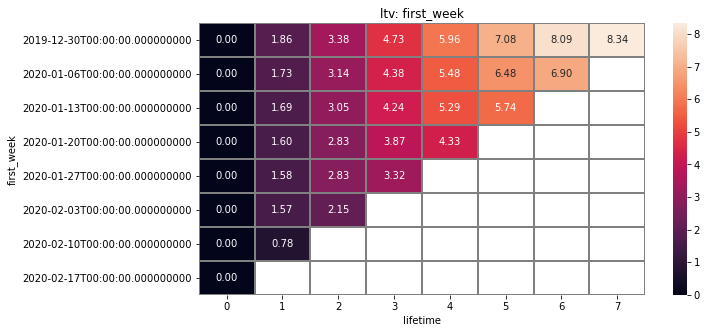

In [17]:
plt.figure(figsize=(10, 5))
plt.title('ltv: ' + 'first_week')
sns.heatmap(ltv_pivot, annot=True, linewidths=1, linecolor='gray', fmt=".2f")
plt.show()

Calculate average LTV by everyweek and cohorts:

In [18]:
weekly_mean_ltv = ltv.groupby('lifetime').agg({'ltv': 'mean'}).reset_index()
weekly_mean_ltv

,lifetime,ltv
0,0,0.000000
1,1,1.544286
2,2,2.896667
3,3,4.108000
4,4,5.265000
5,5,6.433333
6,6,7.495000
7,7,8.340000


#### 1.2. Predict what LTV will be for six months.

To predict the LTV, we will use the following logarithmic formula:

a + b * ln(t), where:

t - number of weeks;

I'll using <b>scipy.optimize curve_fit</b>

In [19]:
x = weekly_mean_ltv[weekly_mean_ltv['lifetime'] != 0].lifetime
y = weekly_mean_ltv[weekly_mean_ltv['lifetime'] != 0].ltv
y = y.round(2)

coefficient, cov = optimize.curve_fit(lambda t, a, b: a + b * np.log(t), x, y)
coefficient

array([0.87286874, 3.51546646])

In [20]:
ltv_26week = coefficient[0] + coefficient[1] * np.log(26)
ltv_26week

12.326597844468163

LTV in six months (week 26) will be $12.32.

#### 1.3 Let's build a graph that will display the actual LTV curve against the background of the predicted LTV curve.

Since we have data about the service and subscriptions, and, accordingly, LTV for 8 weeks. Let's start building a predicted LTV curve from week 8:

In [21]:
prediction_ltv = np.hstack([weekly_mean_ltv.lifetime, [8, 12, 16, 20, 26]])

Let's write a function to predict LTV:

In [22]:
def prediction_ltv_function(time):
    pred_ltv = coefficient[0] + coefficient[1] * np.log(time)
    return pred_ltv

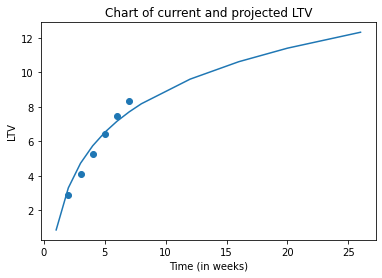

In [23]:
plt.scatter(x[1:], y[1:])
plt.plot(prediction_ltv[1:], prediction_ltv_function(prediction_ltv[1:]))
plt.title('Chart of current and projected LTV')
plt.xlabel('Time (in weeks)')
plt.ylabel('LTV')
plt.show()

#### 1.4 Let's calculate ROMI for 4 weeks and for half (26 week) a year.

Let's see how the investment in marketing pays off if the cost of attracting a paying user is 6 USD.

To calculate this indicator, we will use a simple formula:

(А - В) / В * 100, where:
* <b> A </b>- increase;
* <b> B </b>- marketing costs;

In [24]:
ROMI_4WEEK = (weekly_mean_ltv['ltv'][3] - 6) / 6 * 100
ROMI_4WEEK

-31.533333333333342

In [25]:
ROMI_26WEEK = (prediction_ltv_function(26) - 6) / 6 * 100
ROMI_26WEEK

105.44329740780272

As you can see, after 4 weeks, users are not paying off, since the ROMI is -31.5%.

In six months, users pay off twice, ROMI is more than 100%.